In [18]:
import pandas as pd
import os as os
import numpy as np
import folium as fl
import requests
from folium.plugins import HeatMap
from math import sqrt, radians, cos, sin, atan2
from shapely.geometry import Point
from shapely.ops import unary_union, cascaded_union
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import json
import seaborn as sb
file = open('key.json')
key = json.load(file)['key']

In [45]:
def dist_haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in kilometers (you can change this to miles if needed)
    radius_earth = 6371.0

    # Calculate the distance
    distance = radius_earth * c

    return distance

# Analysis of climbing routes in Washington

This analysis is on a dataset collected from the website: https://www.mountainproject.com

The dataset is made up of climbing routes in Washington, first I'll need to concatenate the files to create a full set for all of Washington

In [51]:
data_files = os.listdir("./data/")
df_WA = pd.read_csv("./data/" + data_files[0])

In [52]:
all_areas_csv = pd.concat([pd.read_csv("./data/"+f) for f in data_files ])
df = all_areas_csv.drop_duplicates()

# Question one: which crags in washington have the highest concentration of well-rated non-trad routes?

First, I'll restrict the dataset to only contain routes which I am going to count as "well-rated" for the sake of this analysis, which will be three or more stars.

In [53]:
df_rated = df[df['Avg Stars'] >= 3]

This pares down the dataset by about 1000 entries, next I will group the dataset by the crag, or "area" that it is listed as part of.

In [54]:
# df_grouped = df_rated.groupby(by = df_rated['Location'], sort = True).count()
df_grouped = df_rated.groupby('Location').agg({'Route':'count','Area Latitude': 'mean' , 'Area Longitude':'mean', 'Avg Stars': 'mean', 'Rating': lambda x: x.mode().iat[0]})
df_grouped['full_name'] = df_grouped.index
df_grouped['area_name'] = df_grouped['full_name'].apply(lambda row: row.split('>')[0])

Then, I can simply search using a boolean condition to find which area has the most routes.

In [55]:
df_grouped[df_grouped['Route'] == df_grouped['Route'].max()]

,Route,Area Latitude,Area Longitude,Avg Stars,Rating,full_name,area_name
Location,,,,,,,
World Wall > World Wall Group > Exit 32; Little Si > North Bend & Vicinity > Central-West Cascades & Seattle > Washington,40,47.49795,-121.7549,3.5825,5.14a,World Wall > World Wall Group > Exit 32; Littl...,World Wall


This dataframe contains the counts of routes which have three or more stars, grouped by area. We can see by searching for the row with the most Routes within our parameters, World Wall is the area with the highest concentration of well-rated routes. It even looks like the most common rating there is 5.14a! Pretty hard crag.

# Question one visualizaiton: 

This data seems like it would be pretty trivial to visualize thanks to the included longitude and latitude, which I could easily plot on a map. To indicate the number of routes in given areas, I will make each marker a circle, with a radius corossponding to the number of routes in the area. 

In [56]:
m = fl.Map(location=[47.594494, -120.312228],
                   zoom_start=10, control_scale=True)

for index, row in df_grouped.iterrows():
#     fl.Marker(location=[row['Area Latitude'], row['Area Longitude']], popup=row['area_name']).add_to(m)
    if (row['Route'] == df_grouped['Route'].max()):
        fl.Circle(location = [row['Area Latitude'], row['Area Longitude']], radius = row['Route']*150, fill = True, popup=row['area_name'], color = 'red').add_to(m)
    else:
        fl.Circle(location = [row['Area Latitude'], row['Area Longitude']], radius = row['Route']*150, fill = True, popup=row['area_name']).add_to(m)

m


This is pretty good, and it shows where exactly our area with the most routes matching our search parameters is. However, I since a lot of these areas are very close together, it might more interesting to group the data somehow, and look at the number of routes in that group. For this, I will use a density cluster algorithm included in scikit, then plot the average longitude and latitude of each cluster.

In [57]:
coords = []
for index, row in df_grouped.iterrows():
    coords.append((row['Area Latitude'], row['Area Longitude']))

scaler = StandardScaler()
scaled_coords = scaler.fit_transform(coords)

epsilon = 0.2
min_samples = 2

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_coords)

df_grouped['cluster'] = clusters
df_clustered = df_grouped.groupby(by=df_grouped['cluster']).agg({
    'Area Latitude':'mean',
    'Area Longitude':'mean',
    'Route':'sum',
    'Avg Stars': 'mean'
})
df_clustered

df_clustered['cluster'] = df_clustered.index
m_clustered = fl.Map(location=[47.594494, -120.312228],
                   zoom_start=10, control_scale=True)

for index, row in df_clustered.iterrows():
#     fl.Marker(location=[row['Area Latitude'], row['Area Longitude']], popup=row['area_name']).add_to(m)
    if (row['Route'] == df_clustered['Route'].max()):
        fl.Circle(location = [row['Area Latitude'], row['Area Longitude']], radius = row['Route']*150, fill = True, color = 'red', popup = row['cluster']).add_to(m_clustered)
    else:
        fl.Circle(location = [row['Area Latitude'], row['Area Longitude']], radius = row['Route']*150, fill = True, popup = row['cluster']).add_to(m_clustered)
              
m_clustered


This is way better, even with the clustering, looks like the region that world wall is part of has the highest concentration of climbing routes matching my search parameters. The region is highlighted in red. This visualizatio also makes the other areas a lot more visible, and shows their relative number of routes.

Possible extensions: 

More data, include Oregon and Idaho as well

Write a custom aggregation function so that I can tell exactly which areas make up these regions

I used an epsilon and min samples wich I thought just made the best visualization, but you could use these variables group by specific areas and regions.

# Question Two: What is the best place to climb in washington within a three hour drive from Walla Walla?

First, I'll need to find the driving time to each of the locations that I am looking at, for this I will use the Google location matrix API.

There is a hangup with using the Google Maps location matrix API, it limits to only 25 locations in the matrix, and the API also costs money, so I will have to take a different approach than just calculating the time to drive to every location in my dataset.

In [10]:
url = "https://maps.googleapis.com/maps/api/distancematrix/json"

origin = "46.062451,-118.340396"

locations = []

for index, row in df_grouped.iterrows():
    locations.append(str(row['Area Latitude']) + ',' + str(row['Area Longitude']))

loc_string = '|'.join(locations)

params = {
    
    "origins" : origin,
    "destinations" : loc_string,
    'key': key
    
}

response = requests.get(url, params=params)

response.json()

{'destination_addresses': [],
 'origin_addresses': [],
 'rows': [],
 'status': 'MAX_ELEMENTS_EXCEEDED'}

First, Ill estimate the maximum kilometers away from Whitman one could drive in three hours. Assuming one is traveling about 60 mph, in three hours, one should travel about 180 miles or 289 kilometers. This means I can focus my search on climbs at this distance.

Now, I can search among routes areas 28km from Whitman college to establish my distance threshold, after that I can assume that anywhere within that threshold is able to be driven to within three hours.

In [58]:

df_grouped['dist_Whitman'] = df_grouped.apply(lambda row: dist_haversine(row['Area Latitude'], row['Area Longitude'], 46.062451, -118.340396), axis = 1)
df_grouped['km//10'] = df_grouped['dist_Whitman'] // 10
df_within_290km = df_grouped[df_grouped['km//10'] == 28]

len(df_within_290km)

12

Thankfully, this is less than 25 :)

Now lets retry the request with it narrowed down.

In [12]:
for index, row in df_within_290km.iterrows():
    locations.append(str(row['Area Latitude']) + ',' + str(row['Area Longitude']))

locations = []

for index, row in df_within_290km.iterrows():
    locations.append(str(row['Area Latitude']) + ',' + str(row['Area Longitude']))

loc_string = '|'.join(locations)
params = {
    
    "origins" : origin,
    "destinations" : loc_string,
    'key': key
    
}

response = requests.get(url, params=params)

distances = response.json()

In [13]:
distances

{'destination_addresses': ['I-90, North Bend, WA 98045, USA',
  'I-90, North Bend, WA 98045, USA',
  'I-90, North Bend, WA 98045, USA',
  'Tye Rd, Leavenworth, WA 98826, USA',
  'Ira Spring Memorial Trail, North Bend, WA 98045, USA',
  'Red Bluff Rd, Stevenson, WA 98648, USA',
  '34841 WA-14, Stevenson, WA 98648, USA',
  'Beacon Rock Trail, Stevenson, WA 98648, USA',
  'Red Bluff Rd, Stevenson, WA 98648, USA',
  'Denny Creek Trail, North Bend, WA 98045, USA',
  'Denny Creek Trail, North Bend, WA 98045, USA',
  'Beacon Rock Trail, Stevenson, WA 98648, USA'],
 'origin_addresses': ['311 Chase Ave, Walla Walla, WA 99362, USA'],
 'rows': [{'elements': [{'distance': {'text': '361 km', 'value': 361442},
     'duration': {'text': '3 hours 26 mins', 'value': 12384},
     'status': 'OK'},
    {'distance': {'text': '361 km', 'value': 361344},
     'duration': {'text': '3 hours 26 mins', 'value': 12381},
     'status': 'OK'},
    {'distance': {'text': '361 km', 'value': 361420},
     'duration': {

In [14]:
meters = []
seconds = []
for loc in distances['rows'][0]['elements']:
    meters.append(loc['distance']['value'])
    seconds.append(loc['duration']['value'])
df_traveltime = pd.DataFrame({'time_sec':seconds, 'distance_meters':meters})
df_traveltime['distance_km'] = df_traveltime['distance_meters'] // 1000
df_traveltime['time_hr'] = df_traveltime['time_sec'] / 3600 

I have a relateive maximum now, if I were to be able to narrow dow the max with more requests, larger requests and more money for the API, I think I could get a better reading

next step is to pare down my dataset to locations within the distance threshold, so that I can narrow down the search within that threshold.

In [15]:
df_within_3hr = df_grouped[df_grouped['km//10'] < 333635 // 10000]

In [16]:
df_temp = df_within_3hr[df_within_3hr['Avg Stars'] == df_within_3hr['Avg Stars'].max()]
df_temp[df_temp['dist_Whitman'] == df_temp['dist_Whitman'].min()]

,Route,Area Latitude,Area Longitude,Avg Stars,Rating,full_name,area_name,cluster,dist_Whitman,km//10
Location,,,,,,,,,,
Pictograph Rock > Tumtum > Spokane Area > Northeast Corner & Spokane > Washington,1,47.83934,-117.75628,4.0,5.10a,Pictograph Rock > Tumtum > Spokane Area > Nort...,Pictograph Rock,9,202.492786,20.0


Looks like we have a good candidate for the best place to climb within a three hour drive, Pictograph Rock. Again, due to my inability to get the travel times for the entire dataset, this is the best estimate that I can make. 

# Question two visualization

I will make a plot showing distance in relation to whitman compared to to average star rating. Over that, I will plot my clustered dataset, which should match up with any clusters that I see in the raw, grouped areas.

[Text(0.5, 0, 'Distance from Whitman (KM)')]

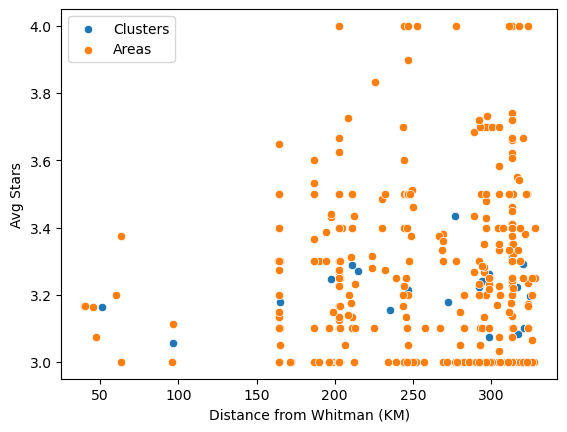

In [70]:
df_clustered['dist_Whitman'] = df_clustered.apply(lambda row: dist_haversine(row['Area Latitude'], row['Area Longitude'], 46.062451, -118.340396), axis = 1)
df_close_clusters = df_clustered[df_clustered['dist_Whitman'] <= 333635 // 1000]
sb.scatterplot(data = df_close_clusters, x = 'dist_Whitman', y = 'Avg Stars', label = 'Clusters')

sb.scatterplot(data = df_within_3hr, x = "dist_Whitman", y = "Avg Stars", label = 'Areas').set(xlabel = 'Distance from Whitman (KM)')


Looks like farther from Whitman you go, the more and higher rated the routes get. And my clustering algorithm seems to be pretty accurate, as a lot of the clusters match up with corrosponding clusters of data.

extensions: 
    If I were able to get the entire driving dataset, I think I could make some interesting visualizations with that.

Sources:

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
https://stackoverflow.com/questions/66603688/return-a-dataframe-row-per-cluster-using-dbscan
https://python-visualization.github.io/folium/latest/reference.html
